In [ ]:
!pip install 'portalocker>=2.0.0'

## Importing Libraries

In [ ]:
import torch, torchdata, torchtext
from torch import nn

import time

device = torch.device('cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234 #3 or 5 times - average results
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


In [ ]:
torch.__version__, torchdata.__version__, torchtext.__version__

('2.1.0+cu121', '0.7.0', '0.16.0+cpu')

## Loading the Dataset

In [ ]:
from torchtext.datasets import AG_NEWS
train, test = AG_NEWS()

In [ ]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## Exploratory Data Analysis

In [ ]:
#let's take a look at one example of train
next(iter(train))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [ ]:
#let's check the unique label
set([y for y, x in list(iter(train))])
#{“World”, “Sports”, “Business”, “Sci/Tech”}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


{1, 2, 3, 4}

In [ ]:
train_size = len(list(iter(train)))
train_size

120000

Since 120000 gonna just take up too much of our GPU, we gonna use only 10% of it for training.

In [ ]:
#All DataPipe instance has a handy function called random_split
too_much, train, valid = train.random_split(total_length=train_size,
                                            weights = {"too_much": 0.85, "smaller_train": 0.1,
                                                       "valid": 0.05}, seed=999)

In [ ]:
train_size = len(list(iter(train)))
train_size

12000

In [ ]:
val_size = len(list(iter(valid)))
val_size

6000

In [ ]:
test_size = len(list(iter(test)))
test_size

7600

## Preprocessing

### Tokenizing

The first step is to decide which tokenizer we want to use, which depicts how we split our sentences.

In [ ]:
#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning NLP!")  #some test
tokens

['We', 'are', 'learning', 'NLP', '!']

### Text to Integers (Numeral)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
#see some example
vocab(['here', 'is', 'a', 'unknown', 'word'])

[538, 28, 9, 6978, 2242]

In [ ]:
#we can reverse it....
mapping = vocab.get_itos()

#print 159, for example
mapping[509]

'financial'

In [ ]:
#let's try special symbols
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [ ]:
#so we can 50k+ unique vocabularies!
len(vocab)

38027

## FastText Embeddings

In [ ]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') #small for easy training

In [ ]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [ ]:
fast_embedding.shape   #we have X vocabs, each with a 300 fasttext embedding

torch.Size([38027, 300])

# 1. BiLSTM

$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$

where

$$
\begin{align*}
i_t &= \sigma(\mathbf{W}_{ii}x_t + b_{ii} + \mathbf{W}_{hi}h_{t-1} + b_{hi}) \\
f_t &= \sigma(\mathbf{W}_{if}x_t + b_{if} + \mathbf{W}_{hf}h_{t-1} + b_{hf})\\
g_t &= \text{tanh}(\mathbf{W}_{ig}x_t + b_{ig} + \mathbf{W}_{hg}h_{t-1} + b_{hg})\\
o_t &= \sigma(\mathbf{W}_{io}x_t + b_{io} + \mathbf{W}_{ho}h_{t-1} + b_{ho}) \\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t \\
h_t &= o_t \odot \text{tanh}(c_t)\\
\end{align*}
$$

## 1.1 Preparing the dataloader

In torchtext, first concern is to define the way we want to process the text and the label.

In [ ]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1 #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training

In [ ]:
text_pipeline("We are implementing BiLSTM for news classification.")

[1867, 49, 19134, 0, 14, 263, 0, 6]

In [ ]:
label_pipeline('1')

0

Next, let's make the batch iterator.  Here we create a function <code>collate_fn</code> that define how we want to create our batch.

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>']

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

In [ ]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
val_loader   = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [ ]:
for label, text, length in train_loader:
    break

In [ ]:
label.shape #(batch_size, )

torch.Size([64])

In [ ]:
text.shape #(batch_size, seq len)

torch.Size([64, 141])

In [ ]:
length.shape #(batch_size, )

torch.Size([64])

## 1.2 Designing the model

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers,
                 bidirectional, dropout, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm      = nn.LSTM(
                            emb_dim,
                            hid_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            dropout = dropout,
                            batch_first = True
                        )
        self.fc        = nn.Linear(hid_dim * 2, output_dim)

    def forward(self, text, text_length):
        #text = [batch_size, seq len]
        embedded = self.embedding(text)
        #text = [batch_size, seq len, emb_dim]

        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length.to(device),
                                                            enforce_sorted=False, batch_first=True)

        packed_output, (hn, cn) = self.lstm(packed_embedded)
        #output is basically all the hidden states;  hn is only last hidden state; cn is last cell state

        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        #output = [batch_size, seq len, hidden_dim * num directions]
        #hn     = [num_layers * num_directions, batch_size,  hid_dim]  #3 layers birectional - hn1f, hn1b, hn2f, hn2b, hn3f, hn3b
        #cn     = [num_layers * num_directions, batch_size,  hid_dim]

        hn      = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim = 1)
        #hn     = [batch_size, hidden_dim * num_directions]

        return self.fc(hn)

## 1.3 Training

In [ ]:
def initialize_weight(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [ ]:
input_dim = len(vocab)
hid_dim   = 256
emb_dim   = 300 #fasttext
output_dim = 4 #four types of news

num_layers = 2
bidirectional = True
dropout    = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, num_layers, bidirectional, dropout, output_dim).to(device)
model.apply(initialize_weight)
model.embedding.weight.data = fast_embedding

In [ ]:
import torch.optim as optim
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy(preds, y):
    predicted  = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc        = batch_corr / len(y)
    return acc

In [ ]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc  = 0
    model.train()

    for i, (label, text, text_length) in enumerate(loader):
        label = label.to(device)
        text  = text.to(device)

        predictions = model(text, text_length).squeeze(1)

        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

In [ ]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc  = 0
    model.eval()

    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader):
            label = label.to(device)
            text  = text.to(device)

            predictions = model(text, text_length).squeeze(1)

            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

In [ ]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time

best_valid_loss = float('inf')
num_epochs      = 5

save_path       = f'{model.__class__.__name__}.pt'

train_losses, train_accs, val_losses, val_accs = [],[],[],[]

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = train(model, val_loader,   optimizer, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    #early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal.  Loss: {valid_loss:.3f} | Val Acc: {valid_acc*100:.2f}%')

Epoch: 1 | Time: 9m 12s
	Train Loss: 0.647 | Train Acc: 74.53%
	Val.  Loss: 0.373 | Val Acc: 86.92%
Epoch: 2 | Time: 9m 2s
	Train Loss: 0.219 | Train Acc: 92.50%
	Val.  Loss: 0.181 | Val Acc: 93.88%
Epoch: 3 | Time: 9m 3s
	Train Loss: 0.105 | Train Acc: 96.53%
	Val.  Loss: 0.125 | Val Acc: 95.83%
Epoch: 4 | Time: 9m 15s
	Train Loss: 0.063 | Train Acc: 97.99%
	Val.  Loss: 0.074 | Val Acc: 97.61%
Epoch: 5 | Time: 9m 10s
	Train Loss: 0.032 | Train Acc: 98.89%
	Val.  Loss: 0.038 | Val Acc: 98.82%


## 1.4 Plotting loss and accuracy

Text(0, 0.5, 'loss')

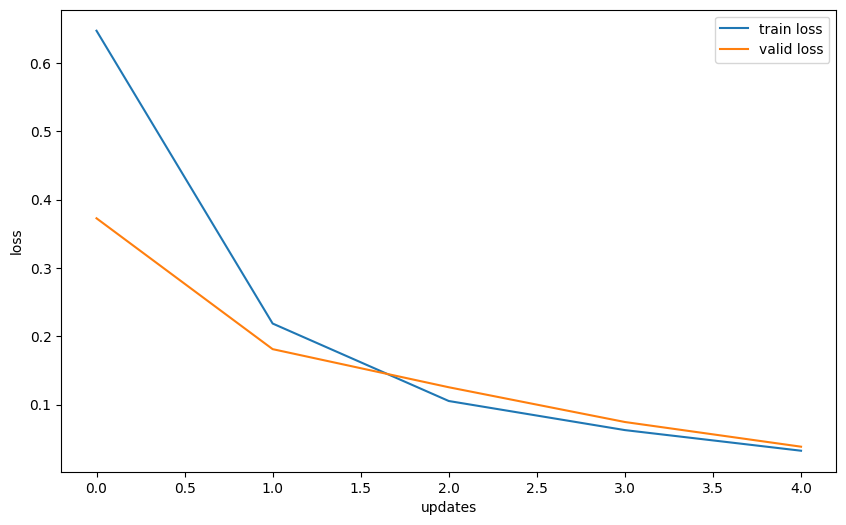

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

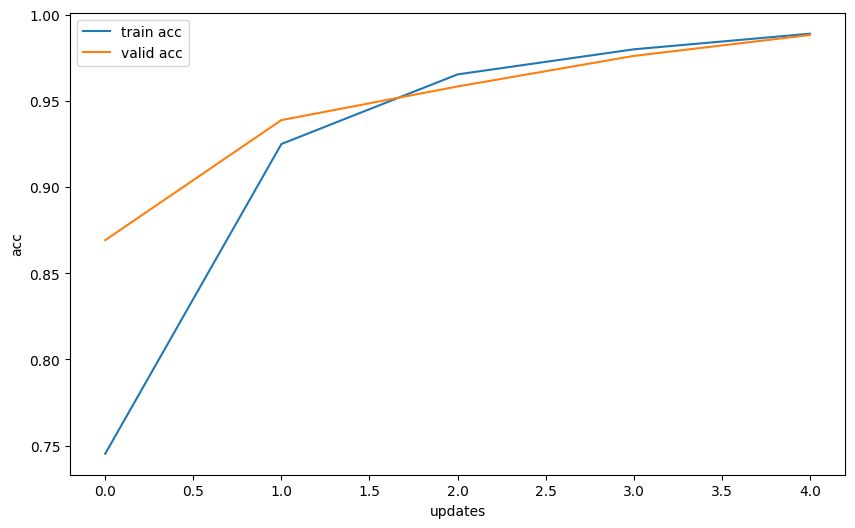

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(val_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [ ]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.602 | Test Acc: 85.96%


## 1.5 Testing on some random news

In [ ]:
test_str = "Google is now falling nonstop. The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([ 180,   28,  250, 1996, 8501,    6,   21,  424,   28, 2231, 1562,  250,
           6])

In [ ]:
text_list = [x.item() for x in text]
text_list

[180, 28, 250, 1996, 8501, 6, 21, 424, 28, 2231, 1562, 250, 6]

In [ ]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [ ]:
text = text.reshape(1, -1)  #because batch_size is 1

In [ ]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [ ]:
text.shape

torch.Size([1, 13])

In [ ]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [ ]:
predict(text, text_length) #2=business

tensor([2])

# 2. CNN

In the same way that a 3x3 filter can look over a patch of an image, a 1x2 filter can look over a 2 sequential words in a piece of text, i.e. a bi-gram. In this part, we will use multiple filters of different sizes which will look at the bi-grams (a 1x2 filter), tri-grams (a 1x3 filter) and/or n-grams (a 1x$n$ filter) within the text.

The intuition here is that the appearance of certain bi-grams, tri-grams and n-grams within the text will be a good indication of the news classification.

## 2.1 Preparing the dataloader

In [ ]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1 #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training

In [ ]:
text_pipeline("We are implementing CNN for news classification.")

[1867, 49, 19134, 2026, 14, 263, 0, 6]

In [ ]:
label_pipeline('1')

0

Since we are using CNN, we don't need the lengths which are needed for LSTM when we use pad_packed_sequence.

In [ ]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>']

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

In [ ]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.  Note that {“World”, “Sports”, “Business”, “Sci/Tech”} maps to {0, 1, 2, 3}

In [ ]:
for label, text in train_loader:
    break

In [ ]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 141])


## 2.2 Designing the model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)

        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[0], emb_dim))

        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[1], emb_dim))

        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[2], emb_dim))

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        #text = [batch_size, seq len]
        #1. embed
        embedded = self.embedding(text)
        #embedded = [batch_size, seq len, emb_size]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch_size, 1, seq len, emb_size]
        #2. convolute
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        #before squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1, 1]
        #after  squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1]

        #3. maxpool
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        #before squeeze = [batch_size, n_filters, 1]
        #after  squeeze = [batch_size, n_filters]

        #dropout
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        #4. fc
        return self.fc(cat)

### Let's see how each layer works

In [ ]:
batch_size, seq_len = 64, 456
input_dim = len(vocab)

input_test = torch.randint(1, input_dim, (batch_size, seq_len))

In [ ]:
embed = nn.Embedding(input_dim, 300)

In [ ]:
embedded = embed(input_test)

In [ ]:
embedded.shape #[batch_size, seq len, emb_size]

torch.Size([64, 456, 300])

In [ ]:
embedded = embedded.unsqueeze(1)

In [ ]:
embedded.shape

torch.Size([64, 1, 456, 300])

In [ ]:
n_filters = 100
filter_sizes = [3, 4, 5]
emb_dim   = 300
conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[0], emb_dim))

In [ ]:
conved_0 = F.relu(conv_0(embedded).squeeze(3))

In [ ]:
conved_0.shape #conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1]

torch.Size([64, 100, 454])

In [ ]:
pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)

In [ ]:
pooled_0.shape

torch.Size([64, 100])

### Using `nn.ModuleList`

In [ ]:
class CNN(nn.Module): #more elegant version
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):

        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (fs, emb_dim))
                                    for fs in filter_sizes
                                    ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]

        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

### Using `nn.Conv1d`

We can also implement the above model using 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.


We'll run our tests using the 2-dimensional convolutional model, but leave the implementation for the 1-dimensional model below.

In [ ]:
class CNN1d(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):

        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = emb_dim,
                                              out_channels = n_filters,
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.permute(0, 2, 1)
        #embedded = [batch size, emb dim, sent len]

        conved = [F.relu(conv(embedded)) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

## 2.3 Training

In [ ]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param)

In [ ]:
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w) #using the Kaiming initialization with values from a normal distribution

tensor([[ 0.2358,  0.4373,  0.8106,  0.4211,  0.4758],
        [-0.8695, -0.8312, -0.5515, -0.3698, -0.7296],
        [-0.4725,  0.3364, -0.2376,  0.4562,  0.0035]])

In [ ]:
input_dim  = len(vocab)
emb_dim    = 300
output_dim = 4 #four classes

#for cnn
dropout = 0.5
n_filters = 100
filter_sizes = [3, 4, 5]

model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #applied the fast text embedding as the initial weights

In [ ]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

11408100
 90000
   100
120000
   100
150000
   100
  1200
     4
______
11769604


The model has so many parameters!!!

In [ ]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [ ]:
def accuracy(preds, y):

    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)

    return acc

In [ ]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout

    for i, (label, text) in enumerate(loader):
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)

        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1

        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

In [ ]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for i, (label, text) in enumerate(loader):
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1)

            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

In [ ]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 2m 17s
	Train Loss: 1.584 | Train Acc: 26.53%
	 Val. Loss: 1.369 |  Val. Acc: 30.58%
Epoch: 02 | Time: 2m 7s
	Train Loss: 1.544 | Train Acc: 27.63%
	 Val. Loss: 1.339 |  Val. Acc: 36.10%
Epoch: 03 | Time: 2m 4s
	Train Loss: 1.510 | Train Acc: 29.14%
	 Val. Loss: 1.312 |  Val. Acc: 42.19%
Epoch: 04 | Time: 2m 5s
	Train Loss: 1.469 | Train Acc: 31.01%
	 Val. Loss: 1.286 |  Val. Acc: 46.85%
Epoch: 05 | Time: 2m 5s
	Train Loss: 1.444 | Train Acc: 31.44%
	 Val. Loss: 1.262 |  Val. Acc: 51.91%


## 2.4 Plotting loss and accuracy

Text(0, 0.5, 'loss')

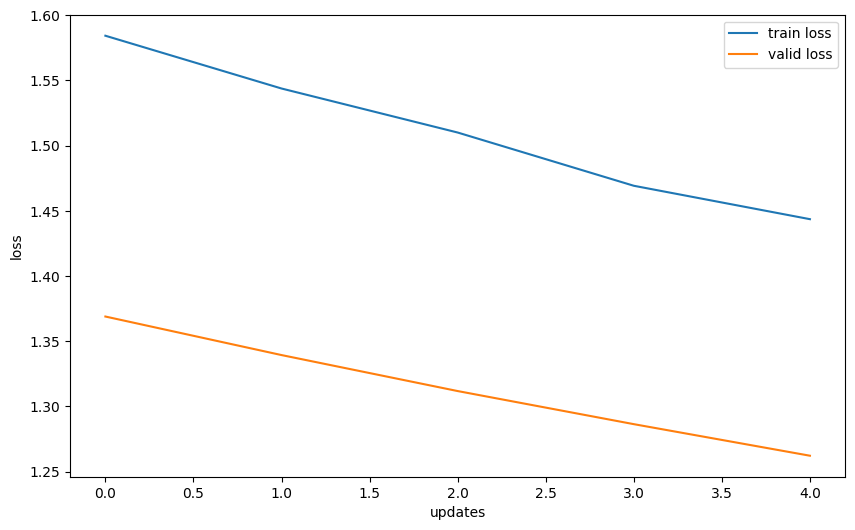

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

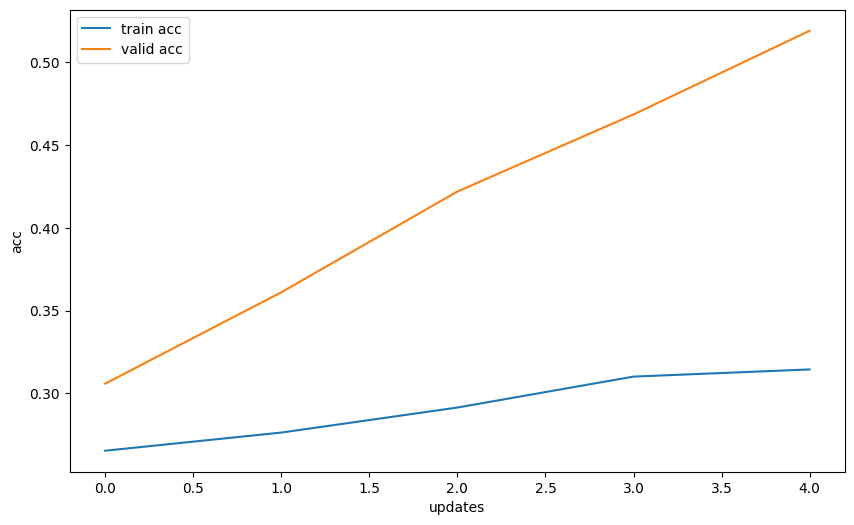

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [ ]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.263 | Test Acc: 52.80%


## 2.5 Testing on some random news

In [ ]:
test_str = "Google is now falling nonstop. The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([ 180,   28,  250, 1996, 8501,    6,   21,  424,   28, 2231, 1562,  250,
           6])

In [ ]:
text_list = [x.item() for x in text]
text_list

[180, 28, 250, 1996, 8501, 6, 21, 424, 28, 2231, 1562, 250, 6]

In [ ]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [ ]:
text = text.reshape(1, -1)  #because batch_size is 1

In [ ]:
text.shape

torch.Size([1, 13])

In [ ]:
def predict(text):
    with torch.no_grad():
        output = model(text).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [ ]:
predict(text) #1=sports

tensor([1])